In [11]:

# ===============================
# 1. Basic Imports and Setup
# ===============================
import os
import random
import math
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score


In [12]:

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [23]:
# ===============================
# 2. Mount Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:

# ===============================
# Load Dataset (only unzip if needed)
# ===============================
BASE_DIR = "/content/chest_xray/chest_xray"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR  = os.path.join(BASE_DIR, "test")
VAL_DIR   = os.path.join(BASE_DIR, "val")

# Only unzip if folder does not exist
if not os.path.exists(BASE_DIR):
    !unzip -q "/content/drive/MyDrive/archive.zip" -d "/content/chest_xray"
    print("Dataset unzipped!")
else:
    print("Dataset already exists. Skipping unzip.")


Dataset already exists. Skipping unzip.


In [25]:
# Check directories
print("Base dataset folders:")
print(os.listdir(BASE_DIR))
for folder in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print(f"{folder} exists? {os.path.exists(folder)} | Contains: {os.listdir(folder)}")



Base dataset folders:
['val', 'train', 'test']
/content/chest_xray/chest_xray/train exists? True | Contains: ['NORMAL', 'PNEUMONIA']
/content/chest_xray/chest_xray/val exists? True | Contains: ['NORMAL', 'PNEUMONIA']
/content/chest_xray/chest_xray/test exists? True | Contains: ['NORMAL', 'PNEUMONIA']


In [26]:
# ===============================
# 3. Create Validation Split (20% from training)
# ===============================
# Create val folder if not exists
if not os.path.exists(VAL_DIR):
    os.makedirs(os.path.join(VAL_DIR, "NORMAL"))
    os.makedirs(os.path.join(VAL_DIR, "PNEUMONIA"))

# Function to split class images
def create_val_split(class_name):
    class_path = os.path.join(TRAIN_DIR, class_name)
    files = os.listdir(class_path)
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=SEED)
    for f in val_files:
        shutil.move(os.path.join(class_path, f), os.path.join(VAL_DIR, class_name, f))

create_val_split("NORMAL")
create_val_split("PNEUMONIA")
print("Validation split created!")


Validation split created!


In [27]:

# ===============================
# 4. Data Generators
# ===============================
IMG_SIZE = 224
BATCH_SIZE = 16

# Training augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directories
train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE),
                                              batch_size=BATCH_SIZE, class_mode='binary', shuffle=True, seed=SEED)
val_gen = val_datagen.flow_from_directory(VAL_DIR, target_size=(IMG_SIZE, IMG_SIZE),
                                         batch_size=BATCH_SIZE, class_mode='binary', shuffle=True, seed=SEED)
test_gen = test_datagen.flow_from_directory(TEST_DIR, target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

print("Class indices:", train_gen.class_indices)


Found 2141 images belonging to 2 classes.
Found 3091 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


In [28]:

# ===============================
# 5. Utility Functions
# ===============================
# Plot training accuracy and loss
def plot_history(history, title="Training History"):
    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Display sample predictions
def show_sample_predictions(model, test_gen, n=6, seed=SEED):
    random.seed(seed)
    idxs = list(range(len(test_gen.filenames)))
    sample_idxs = random.sample(idxs, min(n, len(idxs)))

    cols = min(3, n)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(4*cols, 4*rows))

    for i, idx in enumerate(sample_idxs):
        img_path = os.path.join(TEST_DIR, test_gen.filenames[idx])
        img = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_arr = keras.preprocessing.image.img_to_array(img).astype("uint8")
        arr_norm = img_arr.astype("float32") / 255.0
        pred_score = float(model.predict(np.expand_dims(arr_norm, axis=0))[0][0])
        label_pred = "PNEUMONIA" if pred_score >= 0.5 else "NORMAL"
        true_label = "PNEUMONIA" if test_gen.classes[idx] == 1 else "NORMAL"

        plt.subplot(rows, cols, i+1)
        plt.imshow(img_arr.astype("uint8"))
        plt.title(f"Pred: {label_pred} ({pred_score:.2f})\nTrue: {true_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [29]:

# Evaluate model and print metrics
def evaluate_model(model, model_name):
    print(f"\n===== Evaluating {model_name} =====")
    preds = model.predict(test_gen, verbose=0)
    preds_bin = (preds >= 0.5).astype(int).reshape(-1)
    y_true = np.array(test_gen.classes)

    # Classification report
    print(classification_report(y_true, preds_bin, target_names=["NORMAL","PNEUMONIA"], digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, preds_bin)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Normal","Pneumonia"], yticklabels=["Normal","Pneumonia"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Metrics
    acc = np.mean(y_true == preds_bin)
    prec = precision_score(y_true, preds_bin, zero_division=0)
    rec = recall_score(y_true, preds_bin, zero_division=0)
    f1 = f1_score(y_true, preds_bin, zero_division=0)
    print(f"{model_name} → Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    # Sample predictions
    show_sample_predictions(model, test_gen, n=6)
    return acc, prec, rec, f1


In [30]:

# ===============================
# 6. Build, Train, and Evaluate Models
# ===============================
EPOCHS = 12

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.6315 - loss: 0.6411


134/134 ━━━━━━━━━━━━━━━━━━━━ 98s 660ms/step - accuracy: 0.6320 - loss: 0.6406 - val_accuracy: 0.7422 - val_loss: 0.4731
Epoch 2/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7747 - loss: 0.4686


134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 576ms/step - accuracy: 0.7748 - loss: 0.4685 - val_accuracy: 0.8049 - val_loss: 0.3967
Epoch 3/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8099 - loss: 0.4039


134/134 ━━━━━━━━━━━━━━━━━━━━ 76s 570ms/step - accuracy: 0.8100 - loss: 0.4037 - val_accuracy: 0.8748 - val_loss: 0.3462
Epoch 4/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8545 - loss: 0.3303


134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 580ms/step - accuracy: 0.8545 - loss: 0.3303 - val_accuracy: 0.8874 - val_loss: 0.3104
Epoch 5/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 75s 563ms/step - accuracy: 0.8777 - loss: 0.2970 - val_accuracy: 0.8855 - val_loss: 0.2841
Epoch 6/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8934 - loss: 0.2751


134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 575ms/step - accuracy: 0.8934 - loss: 0.2751 - val_accuracy: 0.8974 - val_loss: 0.2675
Epoch 7/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.8981 - loss: 0.2518


134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 576ms/step - accuracy: 0.8980 - loss: 0.2519 - val_accuracy: 0.9052 - val_loss: 0.2585
Epoch 8/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8995 - loss: 0.2388


134/134 ━━━━━━━━━━━━━━━━━━━━ 76s 569ms/step - accuracy: 0.8995 - loss: 0.2388 - val_accuracy: 0.9068 - val_loss: 0.2546
Epoch 9/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9179 - loss: 0.2352


134/134 ━━━━━━━━━━━━━━━━━━━━ 76s 570ms/step - accuracy: 0.9179 - loss: 0.2351 - val_accuracy: 0.9101 - val_loss: 0.2382
Epoch 10/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9026 - loss: 0.2319


134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 576ms/step - accuracy: 0.9027 - loss: 0.2319 - val_accuracy: 0.9114 - val_loss: 0.2313
Epoch 11/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9186 - loss: 0.2225


134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 584ms/step - accuracy: 0.9186 - loss: 0.2224 - val_accuracy: 0.9130 - val_loss: 0.2253
Epoch 12/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9111 - loss: 0.2183


134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 590ms/step - accuracy: 0.9111 - loss: 0.2183 - val_accuracy: 0.9139 - val_loss: 0.2267


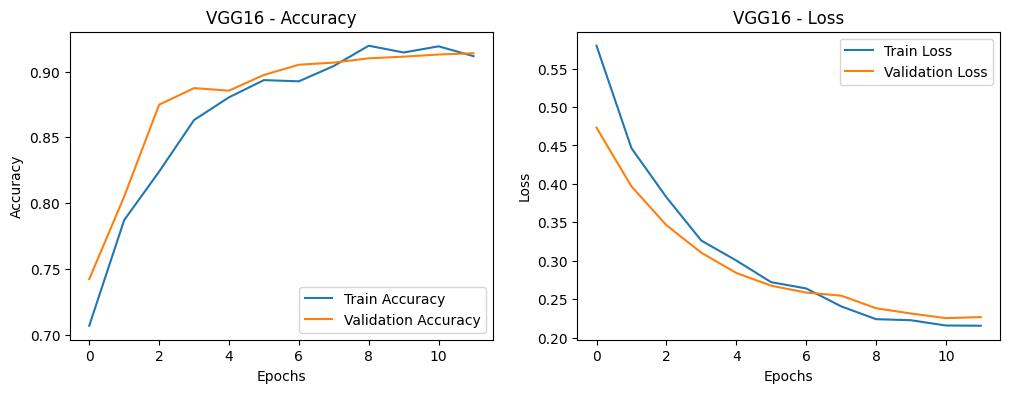


===== Evaluating VGG16 =====
              precision    recall  f1-score   support

      NORMAL     0.9274    0.7094    0.8039       234
   PNEUMONIA     0.8472    0.9667    0.9030       390

    accuracy                         0.8702       624
   macro avg     0.8873    0.8380    0.8534       624
weighted avg     0.8773    0.8702    0.8658       624



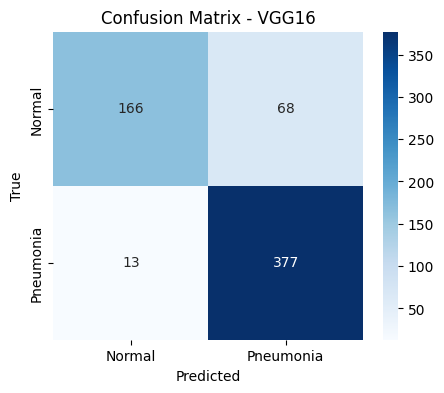

VGG16 → Accuracy: 0.8702, Precision: 0.8472, Recall: 0.9667, F1: 0.9030
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


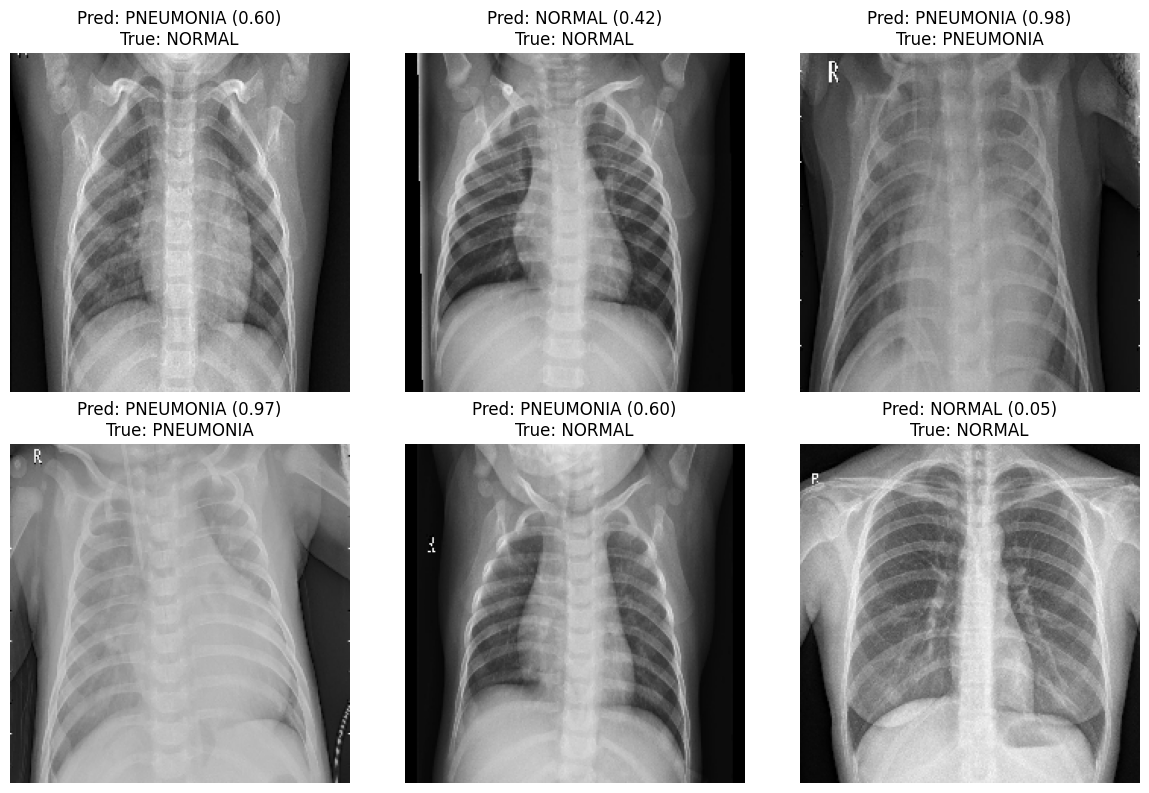

In [31]:

# -------- Model 1: VGG16 --------
MODEL_NAME = "VGG16"
base = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
vgg_model = keras.Model(inputs, outputs)
vgg_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
vgg_model.summary()

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(f"{MODEL_NAME}.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]

# Train
history_vgg = vgg_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks)
plot_history(history_vgg, title="VGG16")
acc_vgg, prec_vgg, rec_vgg, f1_vgg = evaluate_model(vgg_model, "VGG16")



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 100s 653ms/step - accuracy: 0.7008 - loss: 0.6236 - val_accuracy: 0.7422 - val_loss: 0.5486
Epoch 2/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 74s 551ms/step - accuracy: 0.7332 - loss: 0.5754 - val_accuracy: 0.7422 - val_loss: 0.5311
Epoch 3/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 73s 544ms/step - accuracy: 0.7239 - loss: 0.5647 - val_accuracy: 0.7422 - val_loss: 0.5156
Epoch 4/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 72s 543ms/step - accuracy: 0.7446 - loss: 0.5348 - val_accuracy: 0.7422 - val_loss: 0.5001
Epoch 5/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 74s 550ms/step - accuracy: 0.7617 - loss: 0.4967 - val_accuracy: 0.7532 - val_loss: 0.4936
Epoch 6/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 73s 548ms/step - accuracy: 0.7614 - loss: 0.4858 - val_accuracy: 0.7904 - val_loss: 0.4930
Epoch 7/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 75s 560ms/step - accuracy: 0.7826 - loss: 0.4787 - val_accuracy: 0.7486 - val_loss: 0.4618
Epoch 8/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 74s 553ms/step - accuracy: 0.7718 - loss: 

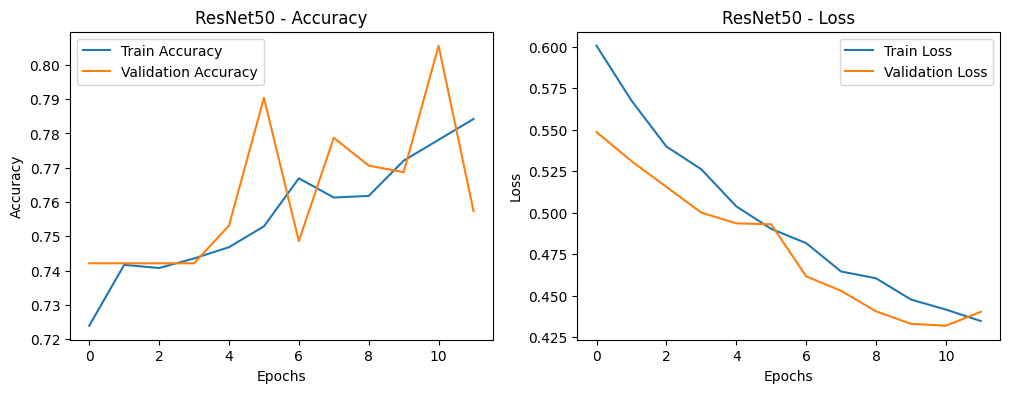


===== Evaluating ResNet50 =====
              precision    recall  f1-score   support

      NORMAL     0.7629    0.3162    0.4471       234
   PNEUMONIA     0.6964    0.9410    0.8004       390

    accuracy                         0.7067       624
   macro avg     0.7296    0.6286    0.6238       624
weighted avg     0.7213    0.7067    0.6679       624



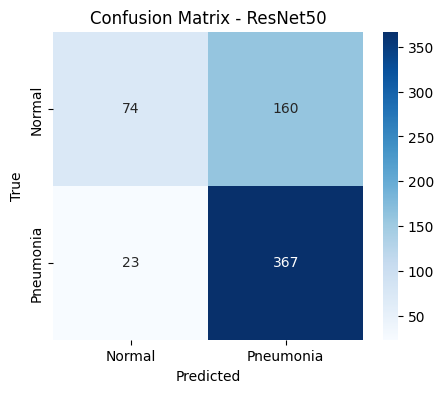

ResNet50 → Accuracy: 0.7067, Precision: 0.6964, Recall: 0.9410, F1: 0.8004
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


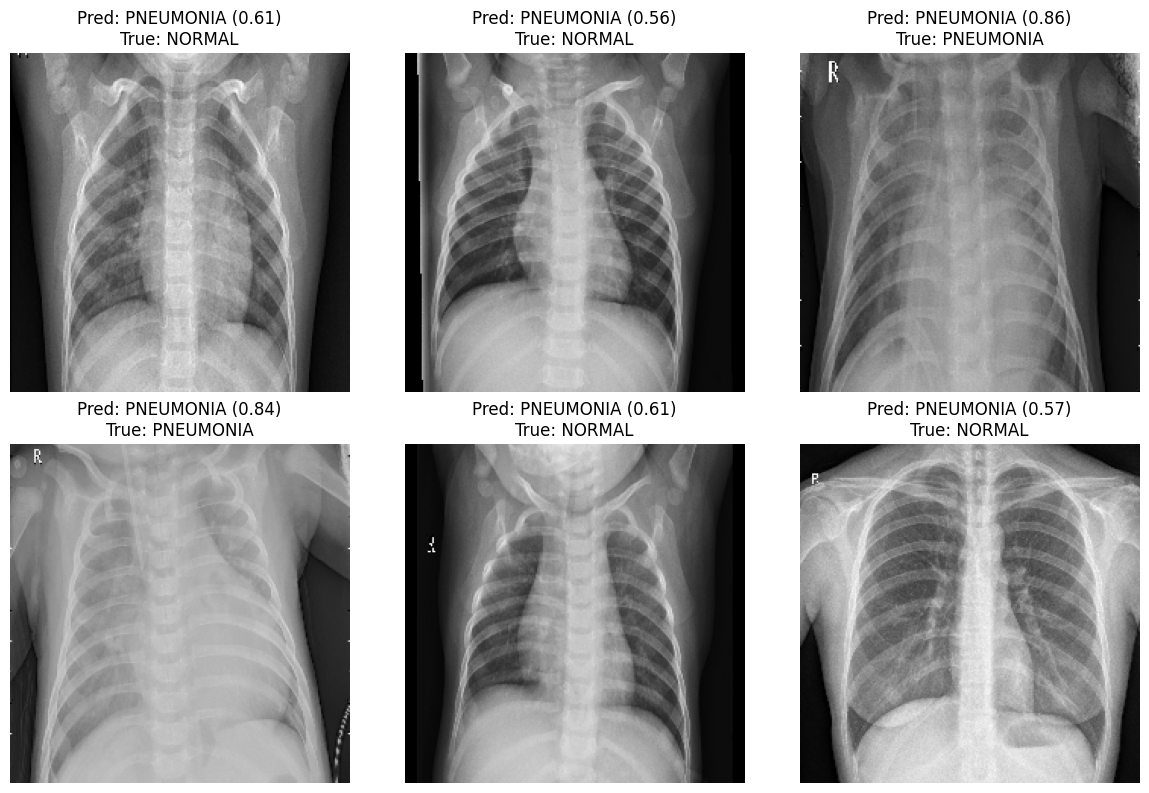

In [32]:

# -------- Model 2: ResNet50 --------
MODEL_NAME = "ResNet50"
base = ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
resnet_model = keras.Model(inputs, outputs)
resnet_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
resnet_model.summary()

# Train
history_resnet = resnet_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks)
plot_history(history_resnet, title="ResNet50")
acc_resnet, prec_resnet, rec_resnet, f1_resnet = evaluate_model(resnet_model, "ResNet50")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 134s 788ms/step - accuracy: 0.6955 - loss: 0.6054 - val_accuracy: 0.7422 - val_loss: 0.5707
Epoch 2/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 71s 531ms/step - accuracy: 0.7506 - loss: 0.5672 - val_accuracy: 0.7422 - val_loss: 0.5711
Epoch 3/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 72s 539ms/step - accuracy: 0.7509 - loss: 0.5655 - val_accuracy: 0.7422 - val_loss: 0.5732
Epoch 4/12
134/134 ━━━━━━━━━━━━━━━━━━━━ 70s 526ms/step - accuracy: 0.7500 - loss: 0.5651 - val_accuracy: 0.7422 - val_loss: 0.5721


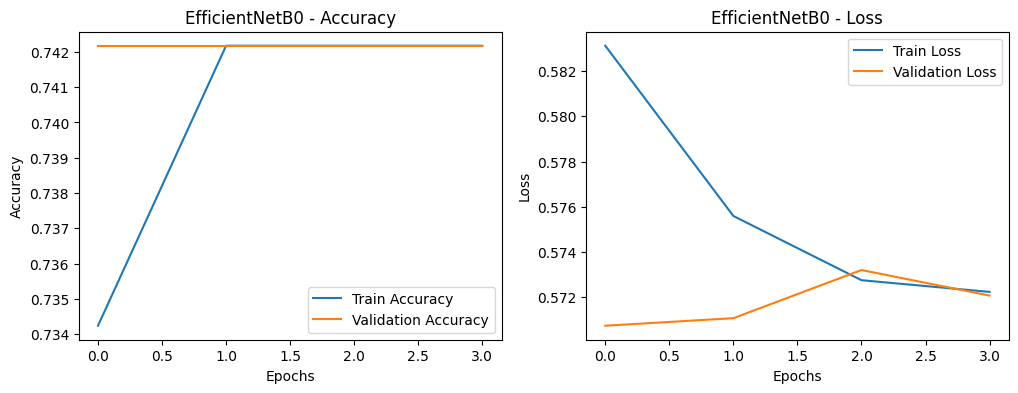


===== Evaluating EfficientNetB0 =====
              precision    recall  f1-score   support

      NORMAL     0.0000    0.0000    0.0000       234
   PNEUMONIA     0.6250    1.0000    0.7692       390

    accuracy                         0.6250       624
   macro avg     0.3125    0.5000    0.3846       624
weighted avg     0.3906    0.6250    0.4808       624



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


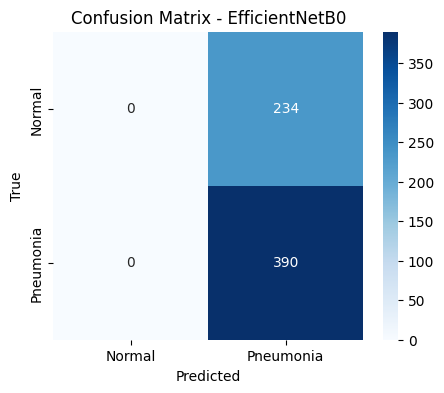

EfficientNetB0 → Accuracy: 0.6250, Precision: 0.6250, Recall: 1.0000, F1: 0.7692
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


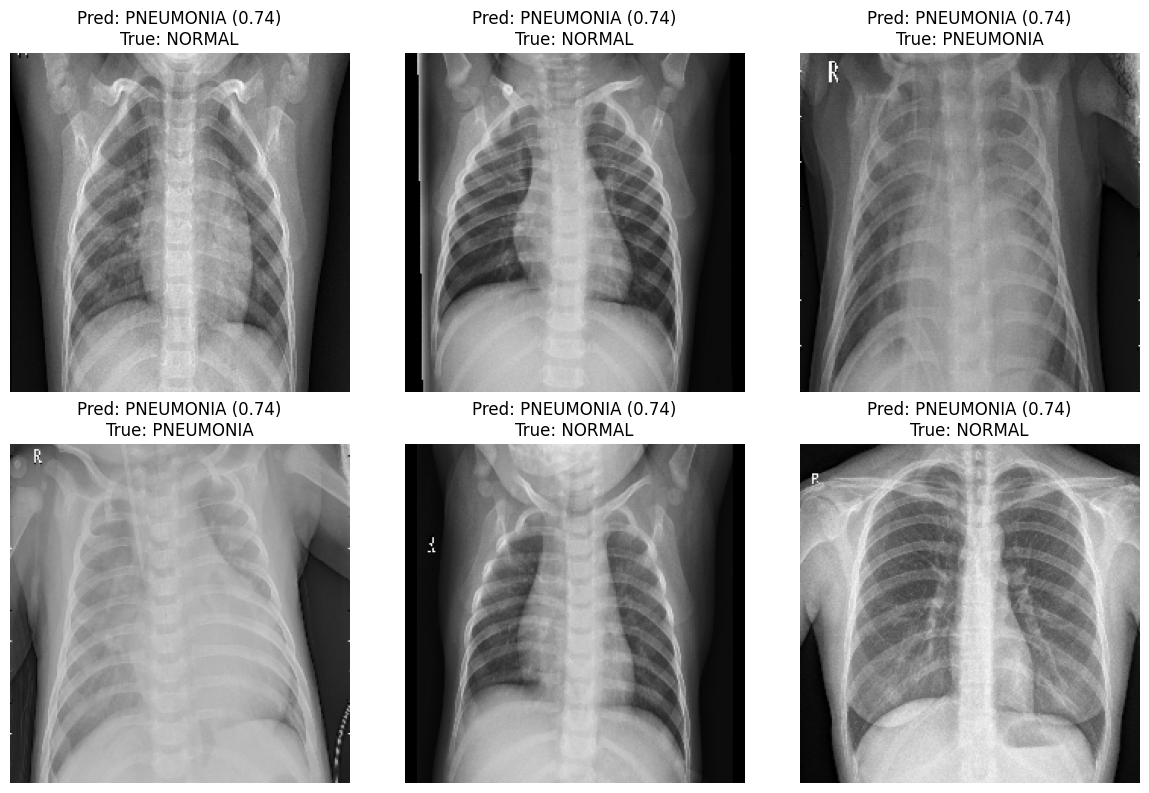

In [33]:

# -------- Model 3: EfficientNetB0 --------
MODEL_NAME = "EfficientNetB0"
base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
efficient_model = keras.Model(inputs, outputs)
efficient_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
efficient_model.summary()

# Train
history_efficient = efficient_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks)
plot_history(history_efficient, title="EfficientNetB0")
acc_eff, prec_eff, rec_eff, f1_eff = evaluate_model(efficient_model, "EfficientNetB0")


In [34]:

# ===============================
# 7. Final Performance Summary
# ===============================
print("\n\n===== FINAL MODEL PERFORMANCE SUMMARY =====\n")
print(f"VGG16 → Accuracy: {acc_vgg:.4f}, Precision: {prec_vgg:.4f}, Recall: {rec_vgg:.4f}, F1: {f1_vgg:.4f}")
print(f"ResNet50 → Accuracy: {acc_resnet:.4f}, Precision: {prec_resnet:.4f}, Recall: {rec_resnet:.4f}, F1: {f1_resnet:.4f}")
print(f"EfficientNetB0 → Accuracy: {acc_eff:.4f}, Precision: {prec_eff:.4f}, Recall: {rec_eff:.4f}, F1: {f1_eff:.4f}")




===== FINAL MODEL PERFORMANCE SUMMARY =====

VGG16 → Accuracy: 0.8702, Precision: 0.8472, Recall: 0.9667, F1: 0.9030
ResNet50 → Accuracy: 0.7067, Precision: 0.6964, Recall: 0.9410, F1: 0.8004
EfficientNetB0 → Accuracy: 0.6250, Precision: 0.6250, Recall: 1.0000, F1: 0.7692


In [37]:
# ================================
# Comparison Table of All Models
# ================================

import pandas as pd

# ----------------------------
# Metrics from model evaluations
# ----------------------------
metrics = {
    "Model": ["VGG16", "ResNet50", "EfficientNetB0"],
    "Accuracy": [0.8702, 0.7067, 0.6250],
    "Precision": [0.8472, 0.6964, 0.6250],
    "Recall": [0.9667, 0.9410, 1.0000],
    "F1 Score": [0.9030, 0.8004, 0.7692]
}

# Create DataFrame
df_metrics = pd.DataFrame(metrics)

# Display styled table with caption
df_metrics.style.set_caption("✅ Comparison of Classification Models on Chest X-Ray Dataset")


,Model,Accuracy,Precision,Recall,F1 Score
0,VGG16,0.870200,0.847200,0.966700,0.903000
1,ResNet50,0.706700,0.696400,0.941000,0.800400
2,EfficientNetB0,0.625000,0.625000,1.000000,0.769200


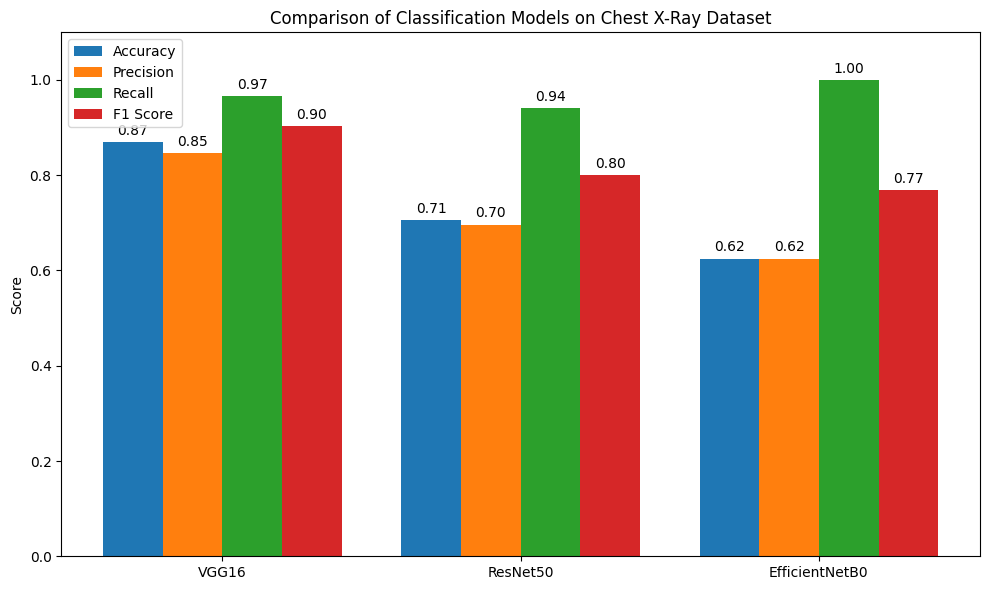

In [38]:
# =====================================
# Bar Chart Visualization of Model Metrics
# =====================================
import matplotlib.pyplot as plt
import numpy as np

# Metrics
models = ["VGG16", "ResNet50", "EfficientNetB0"]
accuracy = [0.8702, 0.7067, 0.6250]
precision = [0.8472, 0.6964, 0.6250]
recall = [0.9667, 0.9410, 1.0000]
f1_score = [0.9030, 0.8004, 0.7692]

x = np.arange(len(models))  # label locations
width = 0.2  # width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy', color='#1f77b4')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision', color='#ff7f0e')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall', color='#2ca02c')
rects4 = ax.bar(x + 1.5*width, f1_score, width, label='F1 Score', color='#d62728')

# Labels and title
ax.set_ylabel('Score')
ax.set_ylim(0, 1.1)
ax.set_title('Comparison of Classification Models on Chest X-Ray Dataset')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for rects in [rects1, rects2, rects3, rects4]:
    autolabel(rects)

plt.tight_layout()
plt.show()


In [35]:
plt.savefig("VGG16_history.png")
plt.savefig("ResNet50_history.png")
plt.savefig("EfficientNetB0_history.png")


<Figure size 640x480 with 0 Axes>